In [2]:
import pandas as pd
import requests
import os

price_df = pd.read_csv("MHWprice_chart.csv")
players_df = pd.read_csv("MHWplayers_chart.csv")

# drop rows with missing values in final price
price_df = price_df.dropna(subset=["Final price"], inplace=True)

price_df["DateTime"] = pd.to_datetime(price_df["DateTime"])
players_df["DateTime"] = pd.to_datetime(players_df["DateTime"])

price_df.drop(price_df.columns[2], axis=1, inplace=True)
players_df.drop(players_df.columns[2], axis=1, inplace=True)

#print(price_df)
#print(players_df)

#set price based on time
merged_df = pd.merge_asof(players_df.sort_values("DateTime"), price_df.sort_values("DateTime"), on="DateTime", direction="backward")

#print(merged_df)

first_valid_index = merged_df[merged_df["Players"] > 100].index.min()
if first_valid_index is not None:
    merged_df = merged_df.iloc[first_valid_index:]

merged_df = merged_df.dropna()

merged_df.to_csv("MHWmerged_table.csv", index=False)

In [3]:
highest_value = merged_df["Final price"].max()
merged_df["Discount"] = (highest_value - merged_df["Final price"]) / highest_value

merged_df['DateTime'] = pd.to_datetime(merged_df['DateTime'])
merged_df['Time Since Release'] = (merged_df['DateTime'] - merged_df['DateTime'].iloc[0]).dt.total_seconds()

print(merged_df)
merged_df.to_csv("merged_table.csv", index=False)

                DateTime   Players  Final price  Discount  Time Since Release
360  2018-08-09 00:00:00  240872.0        59.99  0.000000                 0.0
361  2018-08-10 00:00:00  289952.0        59.99  0.000000             86400.0
362  2018-08-11 00:00:00  318440.0        59.99  0.000000            172800.0
363  2018-08-12 00:00:00  334684.0        59.99  0.000000            259200.0
364  2018-08-13 00:00:00  320909.0        59.99  0.000000            345600.0
...                  ...       ...          ...       ...                 ...
4203 2024-11-23 17:50:00   51238.0        29.99  0.500083         198611400.0
4204 2024-11-23 18:00:00   49077.0        29.99  0.500083         198612000.0
4205 2024-11-23 18:10:00   46905.0        29.99  0.500083         198612600.0
4206 2024-11-23 18:20:00   44959.0        29.99  0.500083         198613200.0
4207 2024-11-23 18:30:00   43343.0        29.99  0.500083         198613800.0

[3847 rows x 5 columns]


In [ ]:
import matplotlib.pyplot as plt

merged_df = pd.read_csv("merged_table.csv")
merged_df["DateTime"] = pd.to_datetime(merged_df["DateTime"])

fig, ax1 = plt.subplots(figsize=(30, 10))

# Plot the Final price on the first y-axis
ax1.plot(merged_df["DateTime"], merged_df["Final price"], color='tab:blue', label="Final price")
ax1.set_xlabel("DateTime")
ax1.set_ylabel("Final price($)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for the Players
ax2 = ax1.twinx()
ax2.plot(merged_df["DateTime"], merged_df["Players"], color='tab:red', label="Players")
ax2.set_ylabel("Players", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Final Price and Players over Time")
plt.show()

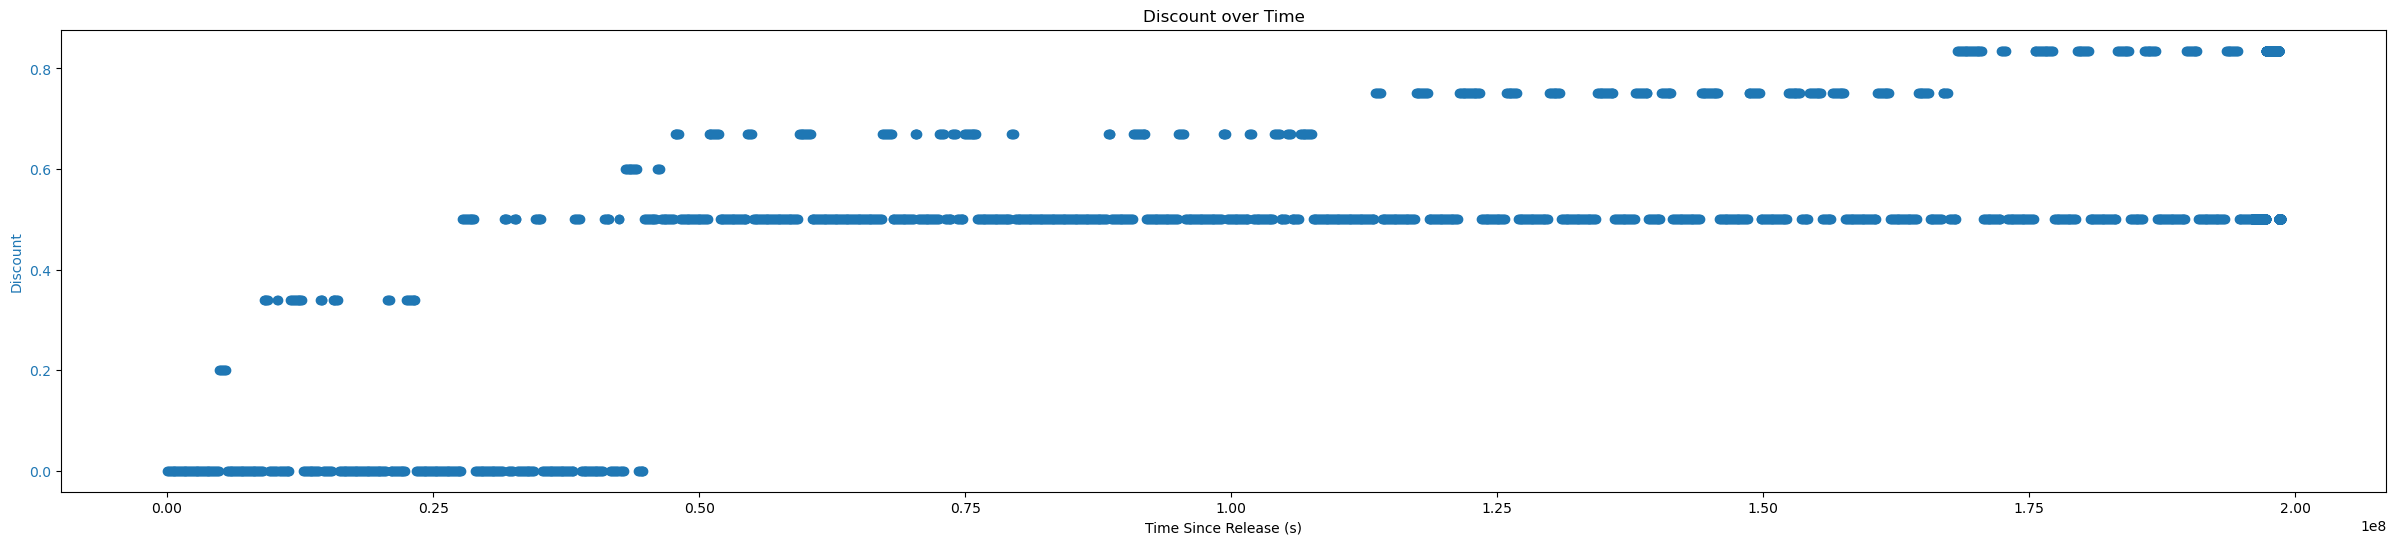

In [5]:
fig, ax = plt.subplots(figsize=(30, 6))

ax.scatter(merged_df['Time Since Release'], merged_df["Discount"], color='tab:blue', label="Discount")
ax.set_xlabel('Time Since Release (s)')
ax.set_ylabel("Discount", color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

plt.title("Discount over Time")
plt.show()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = merged_df[['Time Since Release']].values
y = merged_df['Discount'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_depth = 25  #the depth of the tree
tree_regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
tree_regressor.fit(X_train, y_train)

y_pred = tree_regressor.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.003939364960278571
R^2 Score: 0.9372983877378153


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = merged_df[['Final price']].values
y = merged_df['Time Since Release'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_depth = 25  #the depth of the tree
tree_regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
tree_regressor.fit(X_train, y_train)

y_pred = tree_regressor.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}\n")

#Predicting the date for a user-inputted price
try:
    desired_price = float(input("Enter the price you want to predict the date for: $"))

    while desired_price > merged_df['Final price'].max():
        print("Please Enter a price below the release price, $" + str(merged_df['Final price'].max()) + " for a valid prediction")
        desired_price = float(input("Enter the price you want to predict the date for: $"))
    
    # Predict 'Time Since Release' using the inverse relationship
    time_since_release_pred = tree_regressor.predict([[desired_price]])[0]
    
    # Reference the earliest date in your dataset (assumed as the release date)
    release_date = merged_df["DateTime"].min()
    
    # Calculate the predicted date
    predicted_date = release_date + pd.to_timedelta(time_since_release_pred, unit='s')
    
    print(f"The predicted date for a price of ${desired_price:.2f} is approximately {predicted_date.strftime('%Y-%m-%d')}.")
except ValueError:
    print("Invalid input! Please enter a numerical value for the price.")

Mean Squared Error: 1548866515677839.0
R^2 Score: 0.6594421407501447



Enter the price you want to predict the date for: $ 30


The predicted date for a price of $30.00 is approximately 2023-01-19.


In [10]:
import pandas as pd

price_df = pd.read_csv("MHWprice_chart.csv")
print(price_df.head())  # Inspect the data
print(price_df.isnull().sum())  # Check for missing values

              DateTime  Final price  Historical low
0  2018-07-09 15:50:15        59.99           59.99
1  2018-10-04 17:10:27        47.99           47.99
2  2018-10-12 19:38:56        59.99           47.99
3  2018-11-21 18:56:34        39.59           39.59
4  2018-11-27 19:29:36        59.99           39.59
DateTime          0
Final price       1
Historical low    0
dtype: int64


In [11]:
price_df.to_csv("MHWprice_chart.csv", index=False)


In [12]:
price_df.to_csv("MHWprice_chart_cleaned.csv", index=False)

In [14]:
import pandas as pd
import requests
import os

price_df = pd.read_csv("MHWprice_chart.csv")
players_df = pd.read_csv("MHWplayers_chart.csv")

# drop rows with missing values in final price
price_df.dropna(subset=["Final price"], inplace=True)

# save cleaned price_df to a new CSV file
price_df.to_csv("MHWprice_chart_cleaned.csv", index=False)  # Optional: Save cleaned data to a new file

price_df["DateTime"] = pd.to_datetime(price_df["DateTime"])
players_df["DateTime"] = pd.to_datetime(players_df["DateTime"])

price_df.drop(price_df.columns[2], axis=1, inplace=True)
players_df.drop(players_df.columns[2], axis=1, inplace=True)

#print(price_df)
#print(players_df)

#set price based on time
merged_df = pd.merge_asof(players_df.sort_values("DateTime"), price_df.sort_values("DateTime"), on="DateTime", direction="backward")

#print(merged_df)

first_valid_index = merged_df[merged_df["Players"] > 100].index.min()
if first_valid_index is not None:
    merged_df = merged_df.iloc[first_valid_index:]

merged_df = merged_df.dropna()

merged_df.to_csv("MHWmerged_table.csv", index=False)

In [18]:
import sqlite3

def initialize_database():
    conn = sqlite3.connect('MHW_game_analysis.db')
    cursor = conn.cursor()

    #create game table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS games (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        release_date DATE
        )
    ''')

    #create price trend table 
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS PriceTrends(
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            game_id INTEGER NOT NULL,
            datetime DATETIME NOT NULL,
            price REAL NOT NULL,
            FOREIGN KEY (game_id) REFERENCES games (id)

        )
    ''')

    #create player trends table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS PlayerTrends (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            game_id INTEGER NOT NULL,
            datetime DATETIME NOT NULL,
            players INTEGER NOT NULL,
            FOREIGN KEY (game_id) REFERENCES games (id)
        )
    ''')

    print("database 'MHW_game_analysis.db' and tables have been initialized.")
    conn.commit()
    conn.close()

# initialize the database
initialize_database()


database 'MHW_game_analysis.db' and tables have been initialized.


In [19]:
import sqlite3
import pandas as pd

def insert_data_from_csv(game_name, release_date, price_csv, players_csv):
    conn = sqlite3.connect('MHW_game_analysis.db')
    cursor = conn.cursor()

    #insert game details into game table
    cursor.execute('INSERT INTO games (name, release_date) VALUES (?, ?)', (game_name, release_date))
    #get id of new inserted game
    game_id = cursor.lastrowid

    # load the cleaned price data and players data
    price_df = pd.read_csv(price_csv)  # Now refers to the cleaned CSV
    players_df = pd.read_csv(players_csv)

    #insert price trend data into PriceTrends 
    for _, row in price_df.iterrows():
        cursor.execute('INSERT INTO PriceTrends (game_id, datetime, price) VALUES (?, ?, ?)',
                       (game_id, row["DateTime"], row["Final price"]))
    
    #insert player data into PlayerTrends
    for _, row in players_df.iterrows():
        cursor.execute('INSERT INTO PlayerTrends (game_id, datetime, players) VALUES (?, ?, ?)',
                       (game_id, row["DateTime"], row["Players"]))
    
    conn.commit()
    conn.close()
    print(f"data for '{game_name}' inserted into tables:)")

# insert data for mhw using the cleaned price data
insert_data_from_csv("Monster Hunter: World", "2018-01-26", "MHWprice_chart_cleaned.csv", "MHWplayers_chart.csv")


OperationalError: database is locked